In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from scipy import signal

from matplotlib.backends.backend_pdf import PdfPages

In [2]:
synthetic_dF = np.load('synthetic_dF.npy')

# synthetic_dF0 = np.load('synthetic_dF0.npy')

synthetic_a_soma_signal_smooth = np.load('synthetic_a_soma_signal_smooth.npy', allow_pickle = True)
synthetic_a_dendrite_signal_smooth = np.load('synthetic_a_dendrite_signal_smooth.npy', allow_pickle = True)
synthetic_b_soma_signal_smooth = np.load('synthetic_b_soma_signal_smooth.npy', allow_pickle = True)

synthetic_somatic_event1 = np.load('synthetic_somatic_event1.npy', allow_pickle = True)
synthetic_dendritic_event = np.load('synthetic_dendritic_event.npy', allow_pickle = True)
synthetic_somatic_event2 = np.load('synthetic_somatic_event2.npy', allow_pickle = True)

synthetic_spikes_a_soma = np.load('synthetic_spikes_a_soma.npy', allow_pickle = True)
synthetic_spikes_a_dendrite = np.load('synthetic_spikes_a_dendrite.npy', allow_pickle = True)
synthetic_spikes_b_soma = np.load('synthetic_spikes_b_soma.npy', allow_pickle = True)

synthetic_raw_signal_a_soma = np.load('synthetic_raw_signal_a_soma.npy',allow_pickle = True)
synthetic_raw_signal_a_dendrite = np.load('synthetic_raw_signal_a_dendrite.npy',allow_pickle = True)
synthetic_raw_signal_b_soma = np.load('synthetic_raw_signal_b_soma.npy',allow_pickle = True)

synthetic_a_soma_roi = np.load('synthetic_a_soma_roi.npy',allow_pickle = True)
synthetic_a_dendrite_roi = np.load('synthetic_a_dendrite_roi.npy',allow_pickle = True)
synthetic_b_soma_roi = np.load('synthetic_b_soma_roi.npy',allow_pickle = True)

masks_main = np.load('masks.npy', allow_pickle = True)

In [3]:
pad_signal = np.ones(5)
synthetic_a_soma_signal_smooth = np.append(synthetic_a_soma_signal_smooth, pad_signal)
synthetic_a_dendrite_signal_smooth = np.append(synthetic_a_dendrite_signal_smooth, pad_signal)
synthetic_b_soma_signal_smooth = np.append(synthetic_b_soma_signal_smooth, pad_signal)
len(synthetic_b_soma_signal_smooth)

27005

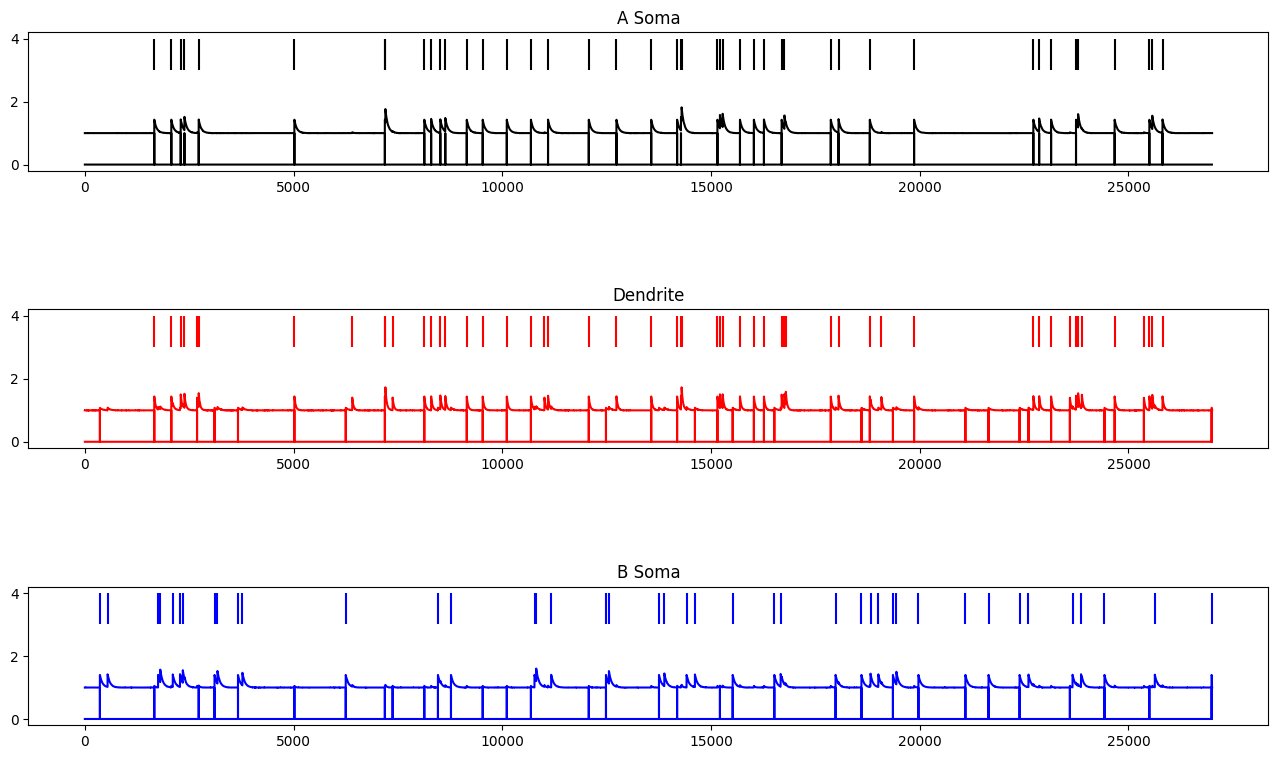

In [4]:
#%matplotlib
fig, axs = plt.subplots(3, 1,figsize=(16,9))
plt.subplots_adjust(hspace=1)

axs[0].vlines(np.flatnonzero(synthetic_spikes_a_soma), 3, 4, 'k')
axs[1].vlines(np.flatnonzero(synthetic_spikes_a_dendrite), 3, 4, 'r')
axs[2].vlines(np.flatnonzero(synthetic_spikes_b_soma), 3, 4, 'b')

axs[0].plot(synthetic_a_soma_signal_smooth, 'k')
axs[0].plot(synthetic_somatic_event1, 'k')
axs[1].plot(synthetic_a_dendrite_signal_smooth, 'r')
axs[1].plot(synthetic_dendritic_event, 'r')
axs[2].plot(synthetic_b_soma_signal_smooth, 'b')
axs[2].plot(synthetic_somatic_event2 , 'b')
axs[0].title.set_text('A Soma')
axs[1].title.set_text('Dendrite')
axs[2].title.set_text('B Soma')

In [5]:
# plt.plot(synthetic_a_dendrite_signal_smooth, '-r')

In [6]:
a_soma_source_prof = synthetic_dF[7:52,7:52,:]
a_dendrite_source_prof = synthetic_dF[42:97,17:42,:]
b_soma_source_prof = synthetic_dF[51:96,32:77,:]

synthetic_a_soma_base_profile = synthetic_a_soma_roi[7:52,7:52]
synthetic_a_dendrite_base_profile = synthetic_a_dendrite_roi[42:97,17:42]
synthetic_b_soma_base_profile = synthetic_b_soma_roi[51:96,32:77]

pad_base_prof_somas = np.ones(10125)
pad_base_prof_somas = pad_base_prof_somas.reshape(45,45,5)

pad_base_prof_dendrite = np.ones(6875)
pad_base_prof_dendrite = pad_base_prof_dendrite.reshape(55,25,5)

a_soma_source_prof = np.append(a_soma_source_prof, pad_base_prof_somas, axis=2)
a_dendrite_source_prof = np.append(a_dendrite_source_prof, pad_base_prof_dendrite, axis=2)
b_soma_source_prof = np.append(b_soma_source_prof, pad_base_prof_somas, axis=2)

np.shape(a_soma_source_prof)

(45, 45, 27005)

In [7]:
def transient_event_detector(signal, theta_upper = 1.1, theta_lower = 1.05): 
    
    N = len(signal)
    
    event = np.zeros(N)
    
    for i in np.arange(N):
        if (signal[i] > theta_upper and signal[i+1] > theta_lower):
            event[i] = 1
        if (signal[i] < theta_lower):
            event[i] = 0
            
    return event

In [8]:
def size(signal):   
    signal_zero = 0                                                                                                                                                
    for x in signal:                                                                                                                                          
        if x == 0 and signal_zero > 0:                                                                                                                             
            yield signal_zero 
            signal_zero = 0
        if x == 1:
            signal_zero += 1
    if signal_zero > 0:
            yield signal_zero
            
def coordinates_and_min(signal):
    transient_coordinates = np.where(signal);
    output = []
    trans_L_minimum = min(np.asarray(list(size(signal))))
    trans_L_sizes = np.asarray(list(size(signal)))
    print(trans_L_minimum)
    print(trans_L_sizes)
    return transient_coordinates

def get_list(transient_coordinates):
    arr = coordinates_and_min(transient_coordinates)
    arr = np.array(arr)
    N_tran = np.size(arr)
    transient_data = arr.reshape(N_tran,)
    transient_data = list(transient_data)
    return transient_data

Here we specifiy the smoothed signal that we would like to call for transient event detection and use later for transient profile creation.

In [9]:
signal_og_a_som = synthetic_a_soma_signal_smooth
signal_og_dend = synthetic_a_dendrite_signal_smooth
signal_og_b_som = synthetic_b_soma_signal_smooth
signal_over_theta = transient_event_detector(signal_og_b_som, 1.15, 1.05)

transient_data = get_list(signal_over_theta)

1
[ 59  61 132  59 148  59  75  59  68  58  73  59 124  59  59  75  59  66
  58  60  59  59  68   1  60   7  59  62  61   7  59  72  59  58  59  59
  60  59   1  66  59  59   7]


In [10]:
MAX_SEQ = 5

def get_seq_len(transient_data, index):
    if index == len(transient_data)-1:
        return 1
    length = 0
    while (index + length + 1 < len(transient_data)) and (transient_data[index + length + 1] == transient_data[index + length]+1):
        length += 1
    return length+1

i = 0
output_transient_data = []
while i<len(transient_data):
    current_seq_len = get_seq_len(transient_data, i)
    current_seq_len = current_seq_len
    #print(current_seq_len, end=" ")
    if current_seq_len > MAX_SEQ:
        output_transient_data += transient_data[i:i+current_seq_len]
    i+=current_seq_len
# output_transient_data

In [11]:
def consecutiveRanges(a, n):
    
    length = 1
    lista_lower = []
    lista_upper = []
     
    if (n == 0):
        return lista
     
    for i in range (1, n + 1):    
        if (i == n or a[i] - a[i - 1] != 1): 
            
            if (length == 1):
                lista.append(a[i - length])   
            else:
                temp_lower = a[i - length]
                temp_upper = a[i - 1]
                lista_lower.append(temp_lower)
                lista_upper.append(temp_upper)
           
            length = 1
        
        else:
            length += 1
    return lista_lower, lista_upper

In [12]:
def transient_profile(transient_signal, source_profile, base_pic, start = 1, finish = 1, step_size = 1):
    
    if finish >= len(transient_signal)-1:
        finish = len(transient_signal)-6
    
    index = np.arange(start-5, finish+5, step_size)
    index_len = np.arange(0,len(index),1)
    transient = transient_signal[index]
    source_profile = source_profile[:,:,index]
    W = transient * source_profile #weighted_frames
    transient_pic = np.sum(W[:,:,index_len],axis=2)
    normalized_trans_pic = transient_pic/sum(transient**2)
    cor = np.mean(ma.corrcoef(ma.masked_invalid(base_pic), ma.masked_invalid(normalized_trans_pic)))
    cor = np.round(cor, 3)
    trans = normalized_trans_pic
    return base_pic, trans, cor

In [13]:
transient_data_to_range_measurement = output_transient_data.copy()
l_transient_data_list = len(transient_data_to_range_measurement)
lista_lower, lista_upper = consecutiveRanges(transient_data_to_range_measurement, l_transient_data_list)

In [14]:
dend_list_lower, dend_list_upper = consecutiveRanges(transient_data_to_range_measurement, l_transient_data_list)
dend_list_lower_save = np.save('dend_list_lower', dend_list_lower)

# a_soma_list_lower, a_soma_list_upper = consecutiveRanges(transient_data_to_range_measurement, l_transient_data_list)
# a_soma_list_lower_save = np.save('a_soma_list_lower', a_soma_list_lower)

# b_soma_list_lower, b_soma_list_upper = consecutiveRanges(transient_data_to_range_measurement, l_transient_data_list)
# b_soma_list_lower_save = np.save('b_soma_list_lower', b_soma_list_lower)

In [15]:
def magazine(smooth_signal, source_profile, base_profile, index_start, index_stop, title = '{0}. dendritic transient', name =''): 
    
    l = len(index_start)
    for i, j in zip(range(l), range(l)):
        
        fig = plt.figure(i)
        fig.set_figheight(55)
        fig.set_figwidth(25)
        
        plt.rcParams.update({'figure.max_open_warning': 0})
        
        plt.subplots_adjust(hspace=0.5)

        rows = 5
        columns = 3
        
        base_pic, trans, cor = transient_profile(smooth_signal, source_profile, base_profile,
                                                index_start[i], index_stop[j], 1)
        
        interval_min = 5
        interval_max = index_stop[i]-index_start[j]+6
        
        #1
        fig.add_subplot(rows, columns, 1,)
        plt.imshow(masks_main)
        plt.title('Total view \n'.format(cor), fontsize =20)

        #2
        fig.add_subplot(rows, columns, 2)
        plt.imshow(base_pic)
        plt.title('A dendrite mask \n', fontsize =20)

        #3
        ax = fig.add_subplot(rows, columns, 3)
        ax.imshow(trans)
        plt.title('Transient profile \n r = {0}'.format(cor), fontsize =20)

        if cor >= 0.5:
            ax.spines["top"].set_color("red")
            ax.spines["left"].set_color("red")
            ax.spines["right"].set_color("red")
            ax.spines["bottom"].set_color("red")
            ax.spines["top"].set_linewidth(5)
            ax.spines["left"].set_linewidth(5)
            ax.spines["right"].set_linewidth(5)
            ax.spines["bottom"].set_linewidth(5)

        #4
        fig.add_subplot(rows, columns, 4)
        plt.plot(synthetic_a_soma_signal_smooth[index_start[i]-5:index_stop[j]+5], 'k')
        plt.title('A Soma', fontsize = 20)
        plt.vlines(interval_min, 0.5, 0.9, 'k')
        plt.vlines(x = interval_min, ymin = 1, ymax = 1.6, colors = 'orange', label = 'vline_multiple - full height')
        plt.vlines(x = interval_max, ymin = 1, ymax = 1.6, colors = 'orange', label = 'vline_multiple - full height')
        
        #5
        fig.add_subplot(rows, columns, 5)
        plt.plot(synthetic_a_dendrite_signal_smooth[index_start[i]-5:index_stop[j]+5], 'r')
        plt.title('A Dendrite', fontsize = 20)
        plt.vlines(interval_min, 0.5, 0.9, 'r')
        plt.vlines(x = interval_min, ymin = 1, ymax = 1.6, colors = 'orange', label = 'vline_multiple - full height')
        plt.vlines(x = interval_max, ymin = 1, ymax = 1.6, colors = 'orange', label = 'vline_multiple - full height')
        
        #6
        fig.add_subplot(rows, columns, 6)
        plt.plot(synthetic_b_soma_signal_smooth[index_start[i]-5:index_stop[j]+5], 'b')
        plt.title('B Soma', fontsize = 20)
        plt.vlines(interval_min, 0.5, 0.9, 'b')
        plt.vlines(x = interval_min, ymin = 1, ymax = 1.6, colors = 'orange', label = 'vline_multiple - full height')
        plt.vlines(x = interval_max, ymin = 1, ymax = 1.6, colors = 'orange', label = 'vline_multiple - full height')
        
        title_num = 1
        title_num = title_num + i
          
        fig.suptitle(title.format(title_num), fontsize=30, weight = 'bold')
        
        pdf_pages = len(lista_upper)
        
        with PdfPages(name) as pdf:
            for fig in range(pdf_pages):
                plt.figure(fig)
                pdf.savefig()

In [16]:
def cor_coefs(smooth_signal, source_profile, base_profile, list_a, list_b):
    cor_list = []
    n = len(list_a)
    for i in range(n):
        base_pic, trans, cor = transient_profile(smooth_signal, source_profile, base_profile, list_a[i], list_b[i], 1)
        cor_list.append(cor)
    return cor_list

Next we extract correaltional coeffiecients from each transients.

In [17]:
# cor_list_a_soma = cor_coefs(synthetic_a_soma_signal_smooth, a_soma_source_prof, synthetic_a_soma_base_profile, lista_lower, lista_upper)
# cor_list_dendritic = cor_coefs(synthetic_a_dendrite_signal_smooth, a_dendrite_source_prof, synthetic_a_dendrite_base_profile, lista_lower, lista_upper)
# cor_list_b_soma = cor_coefs(synthetic_b_soma_signal_smooth, b_soma_source_prof, synthetic_b_soma_base_profile, lista_lower, lista_upper)

In [18]:
# np.save('transient_correl_coeffs/cor_list_a_soma', cor_list_a_soma)
# np.save('transient_correl_coeffs/cor_list_dendritic', cor_list_dendritic)
# np.save('transient_correl_coeffs/cor_list_b_soma', cor_list_b_soma)

Here we call the plot function with the specific details of a soma or the dendrite.

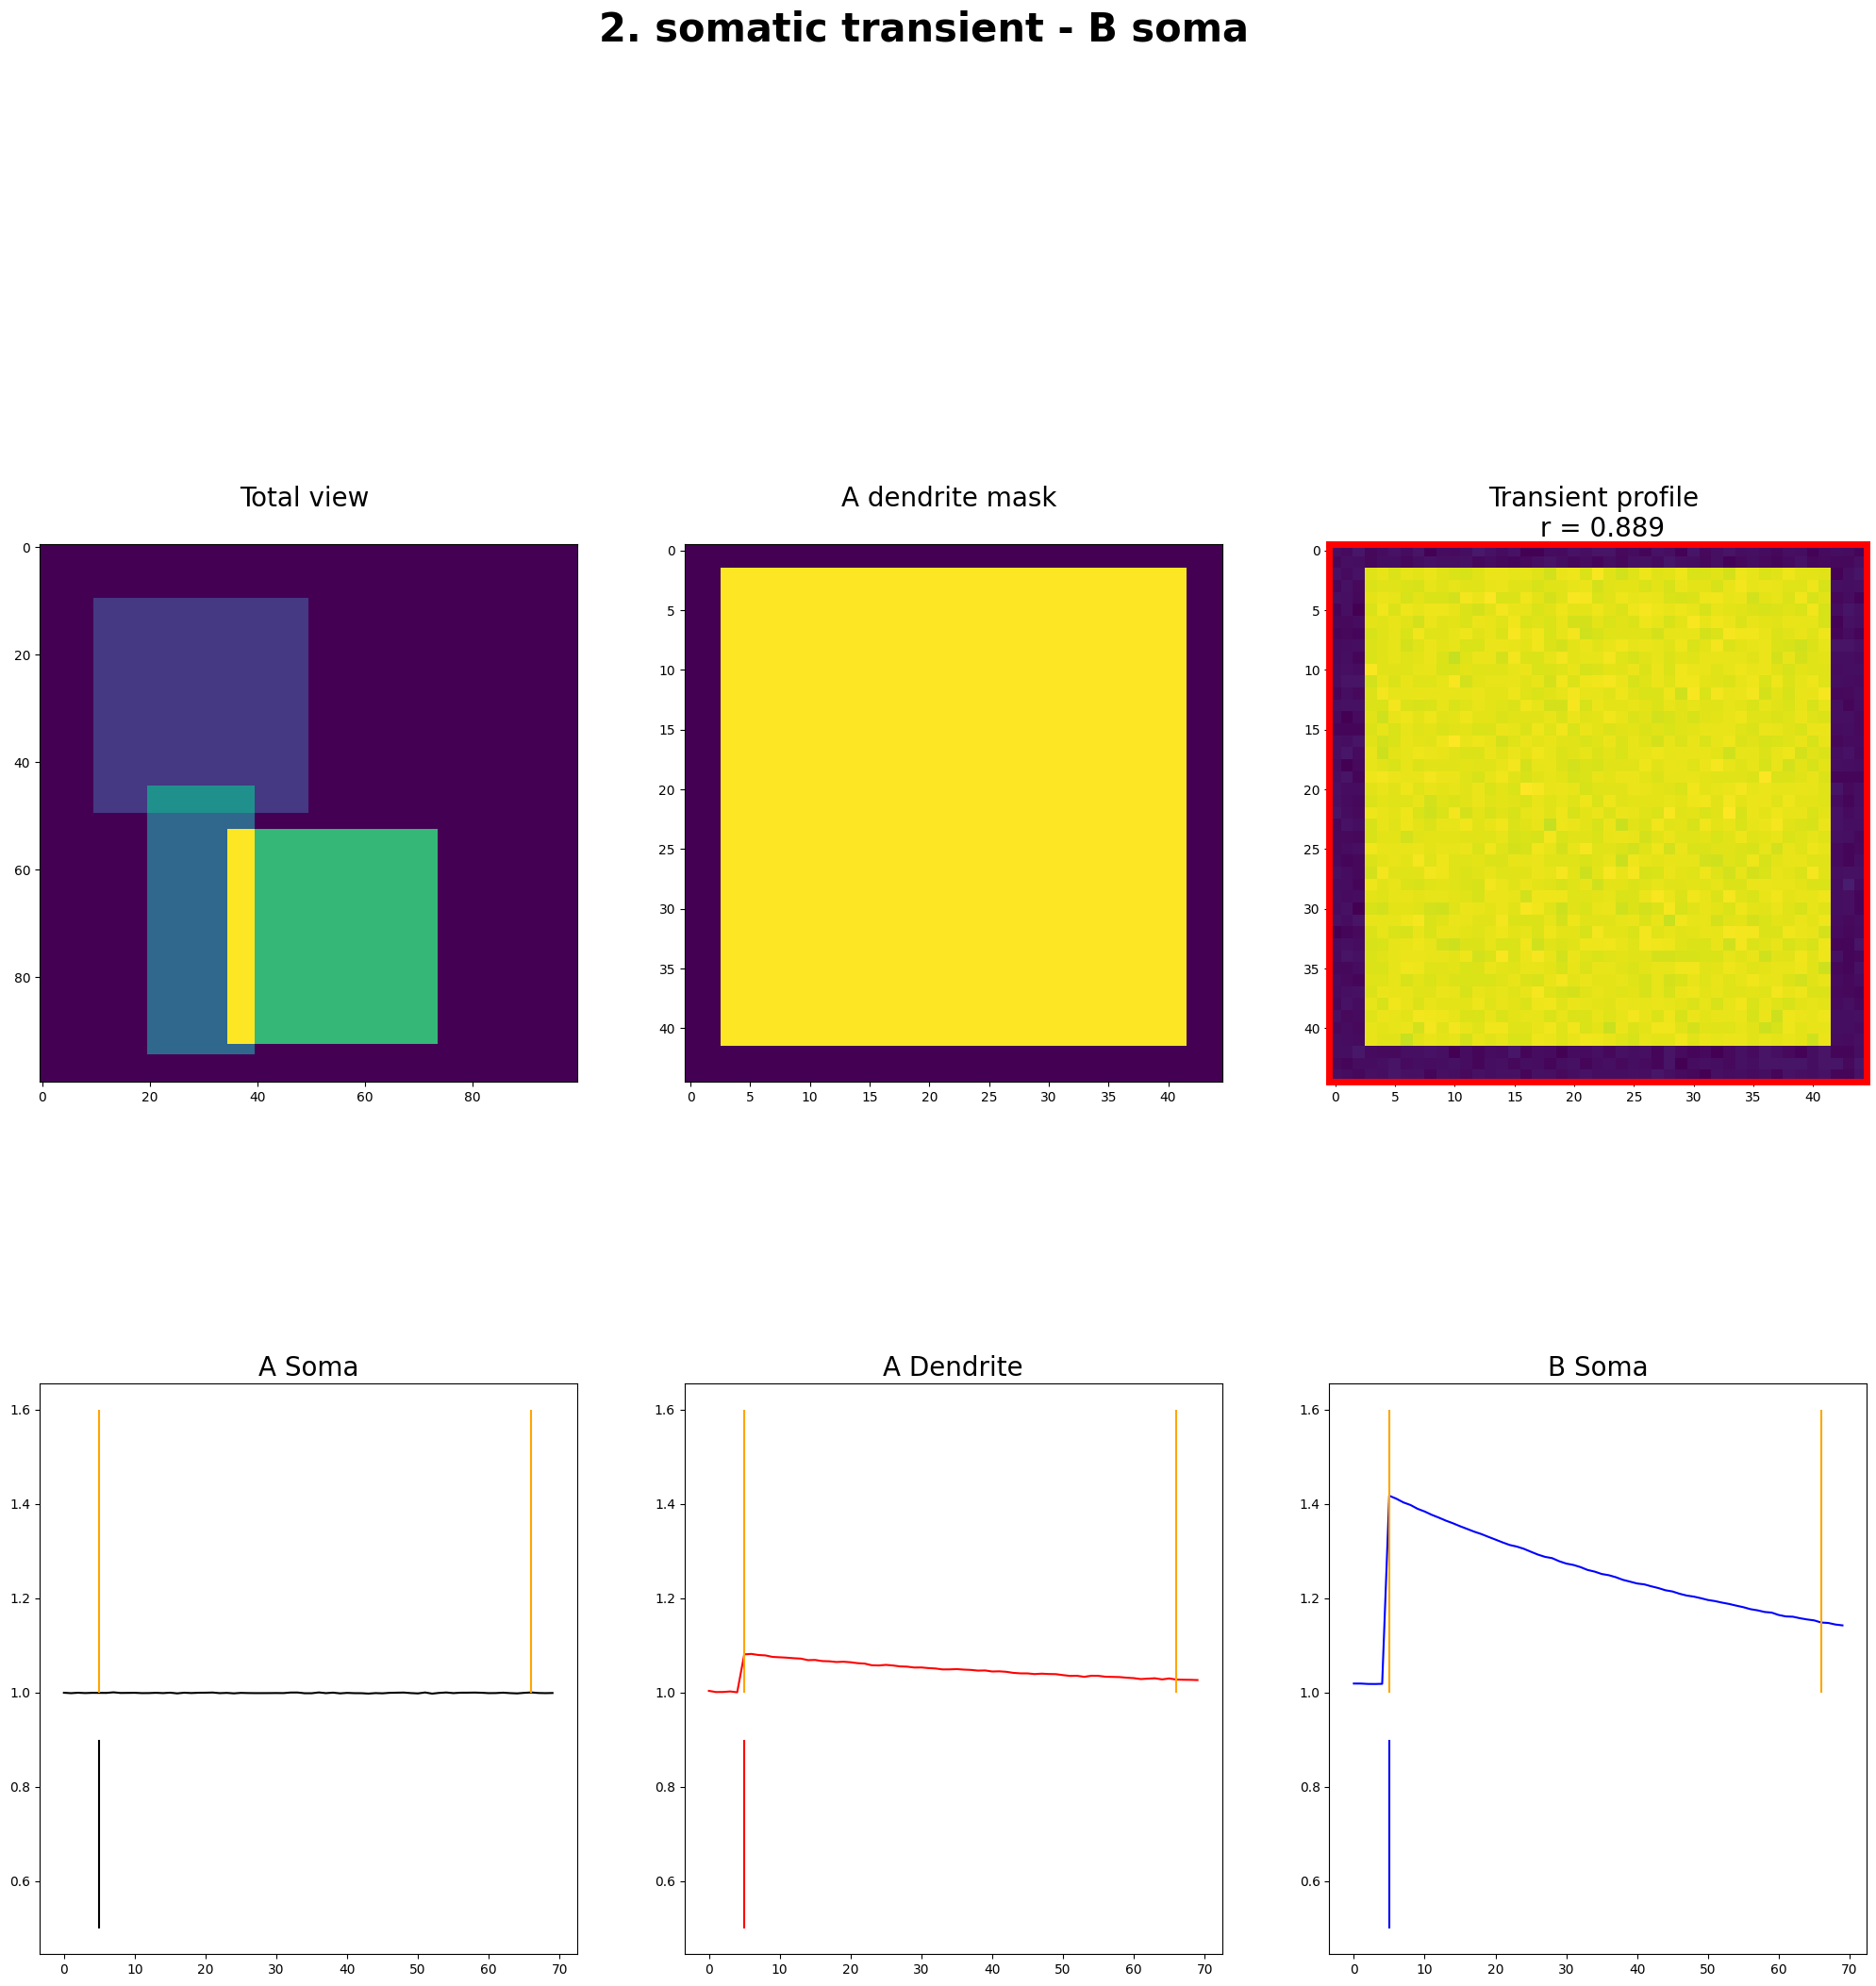

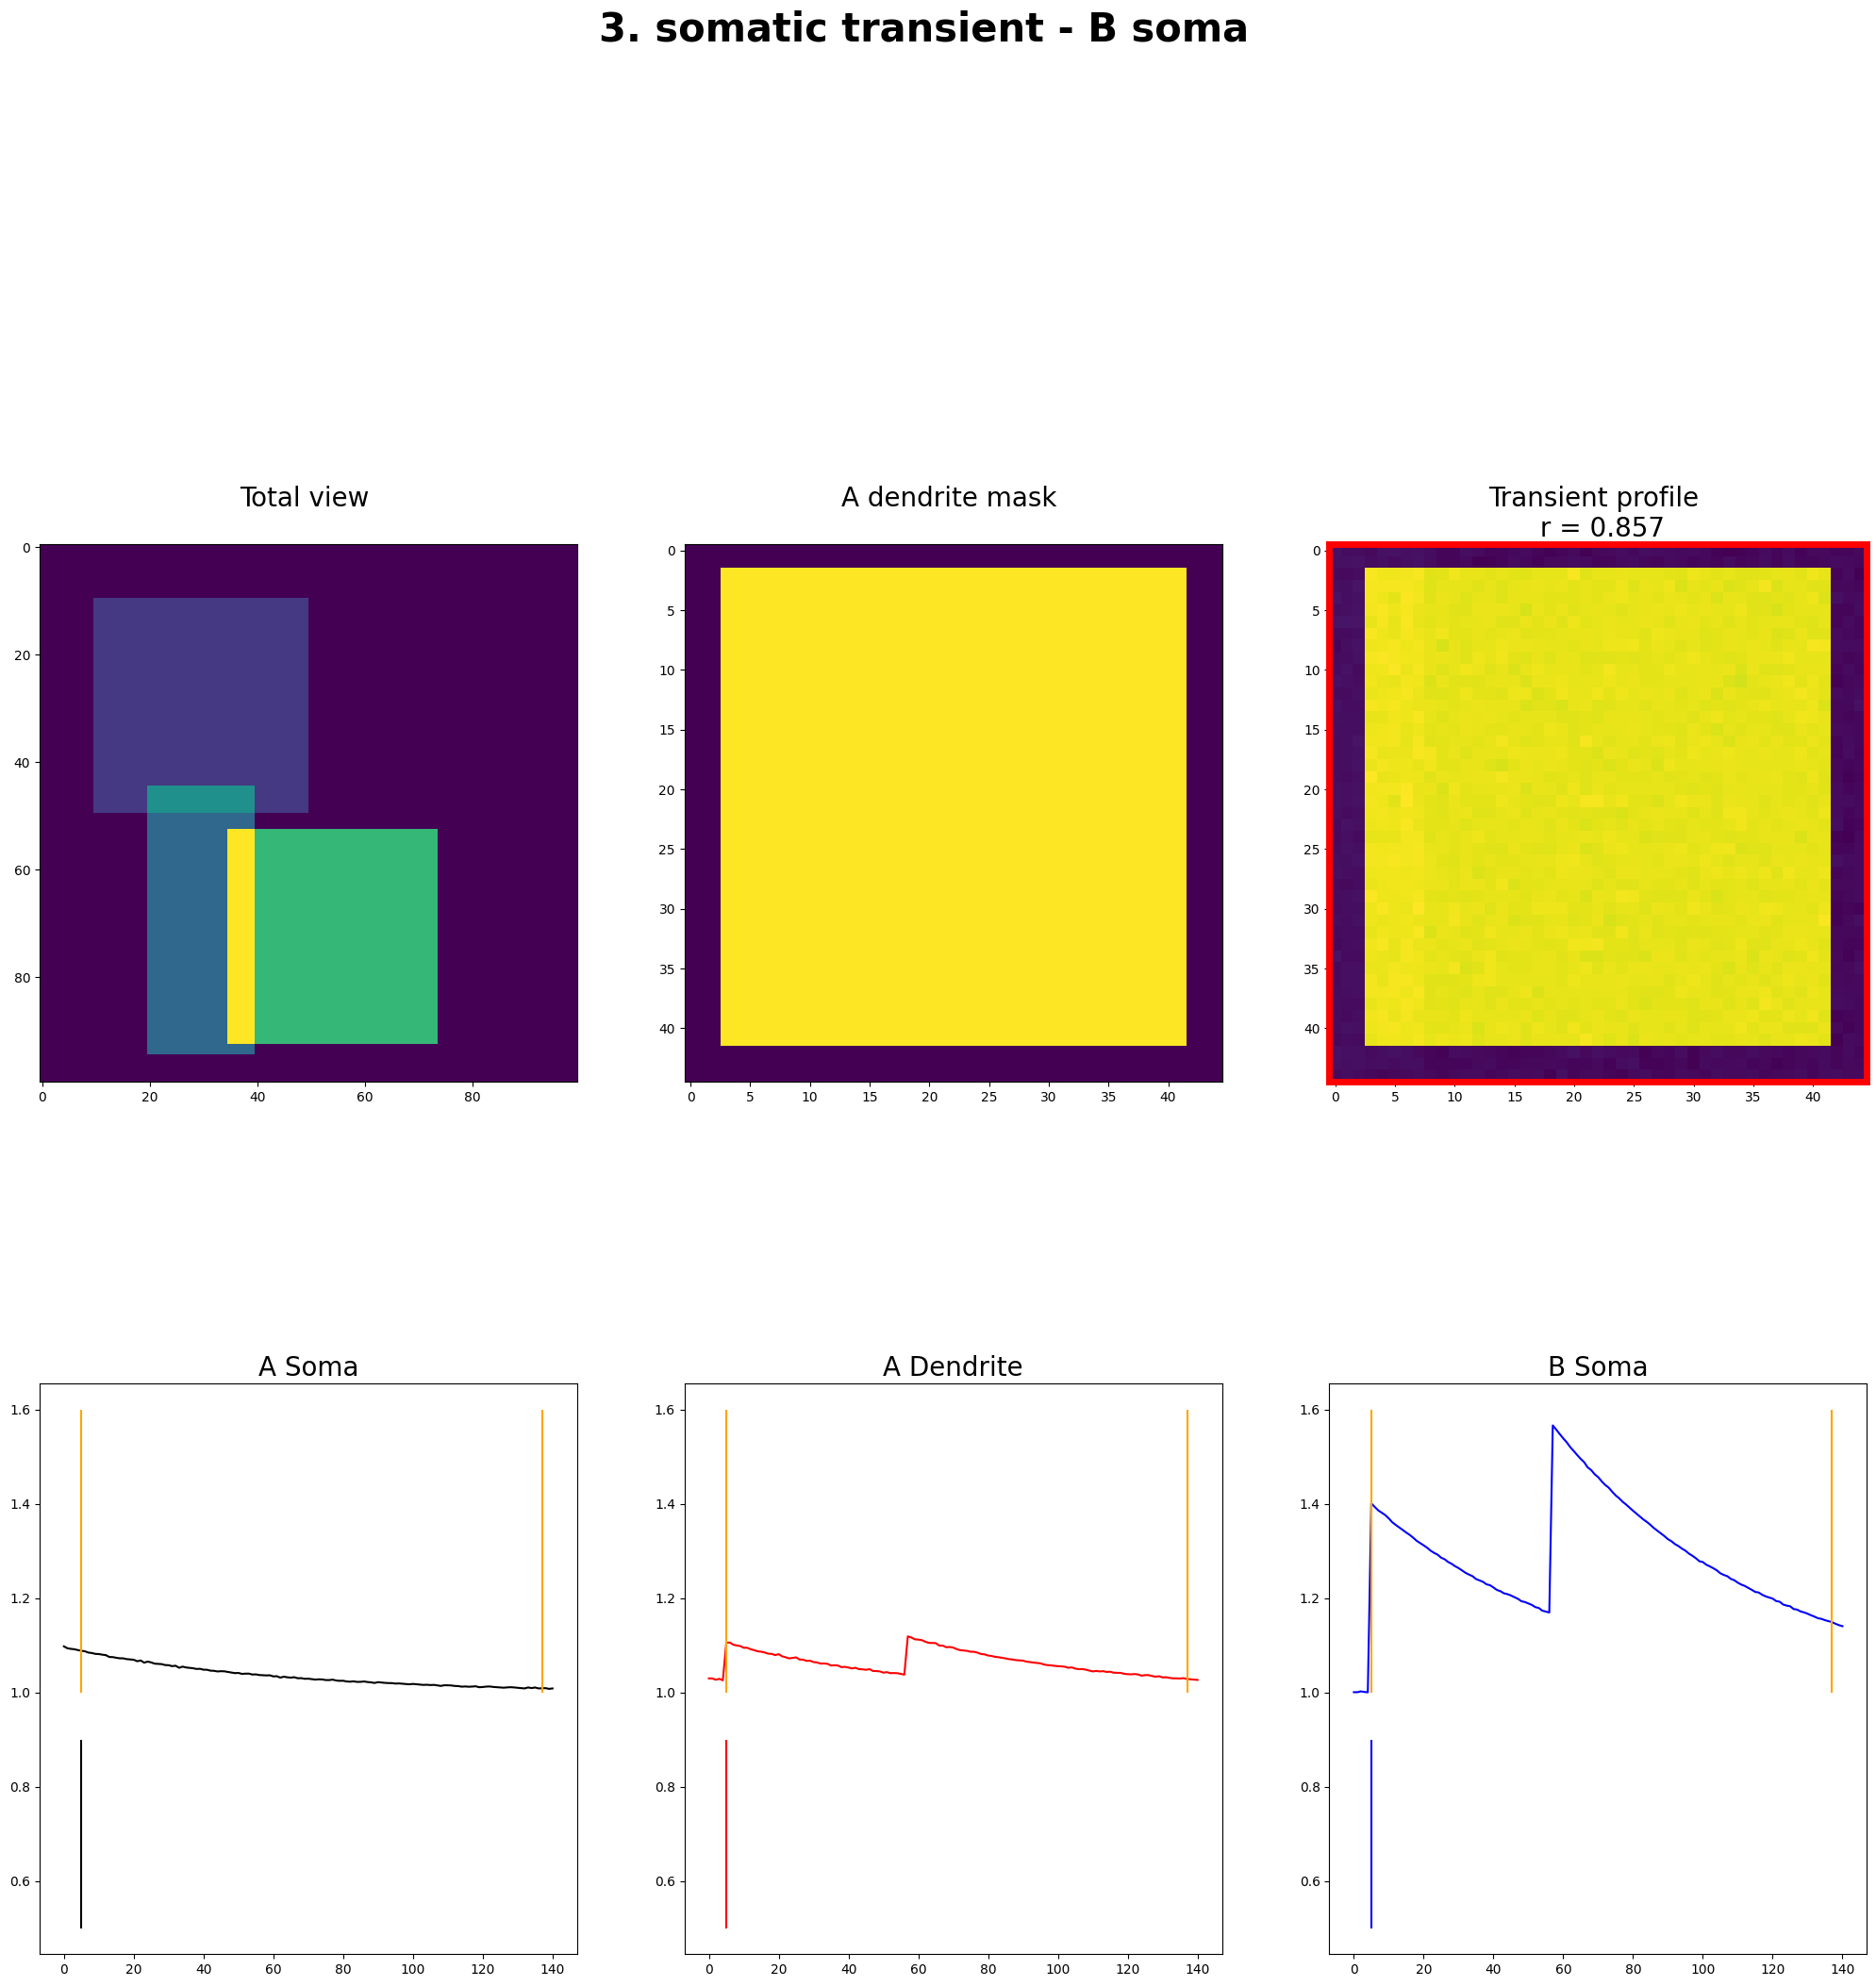

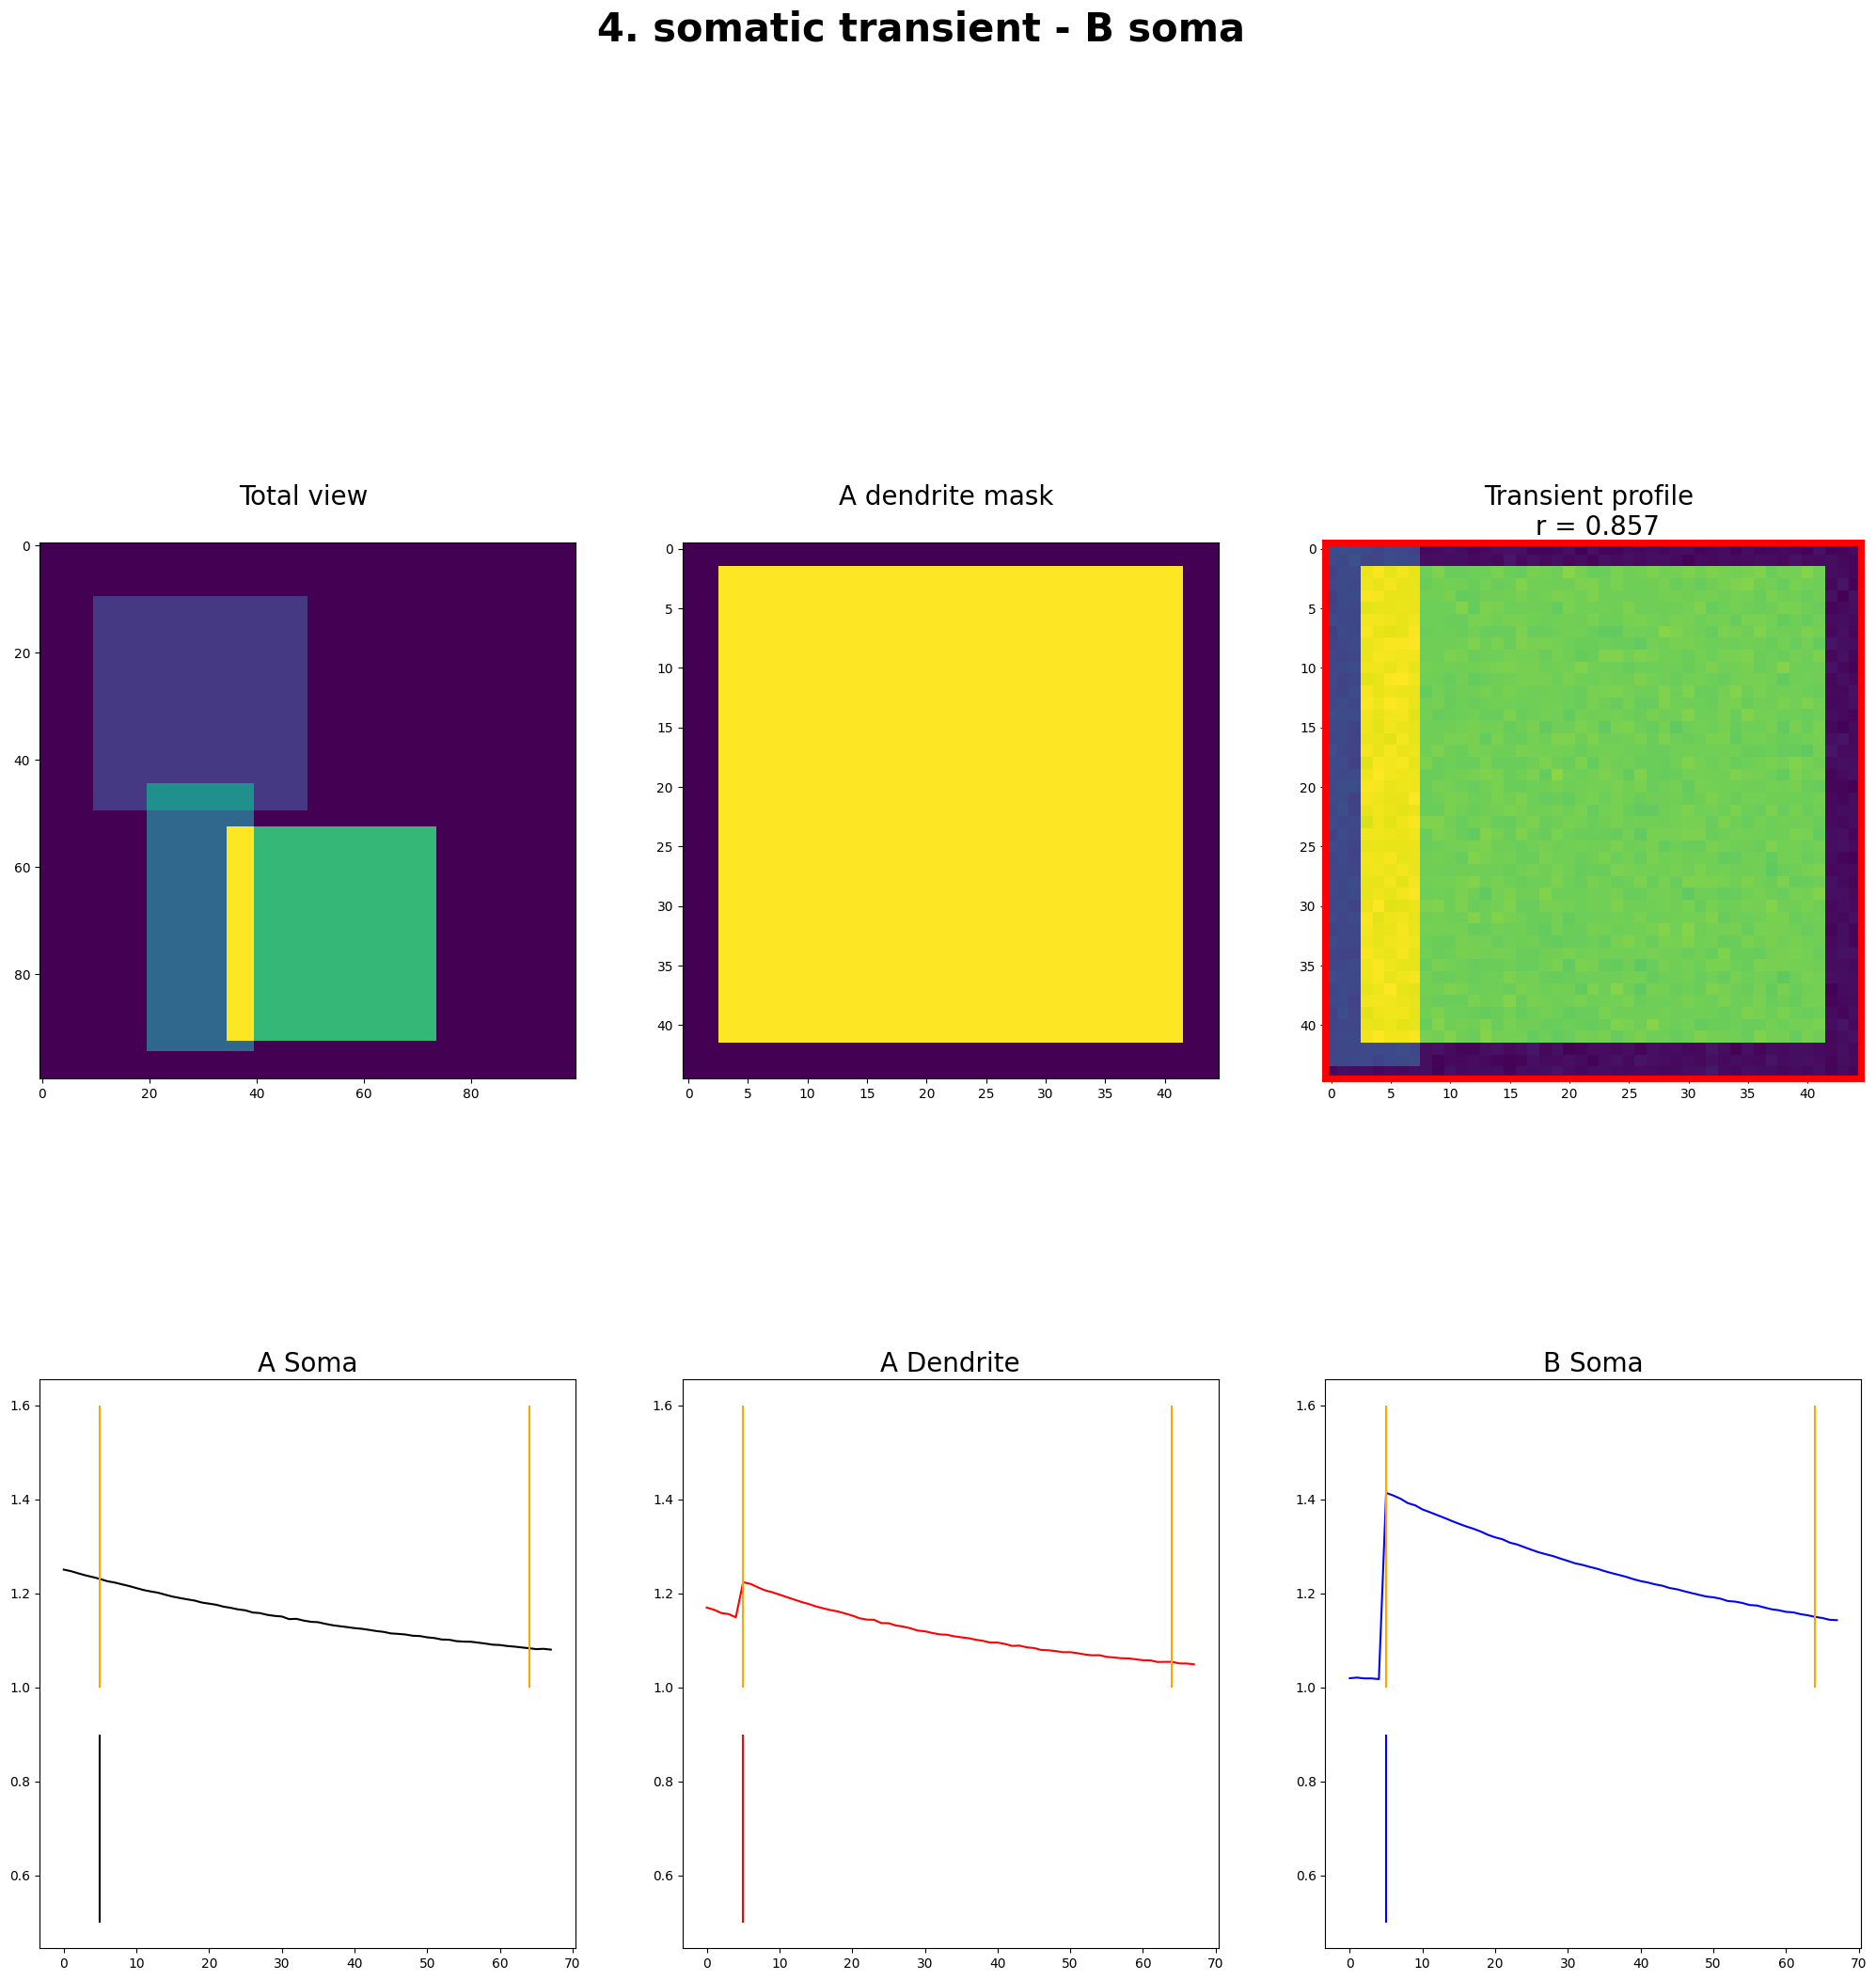

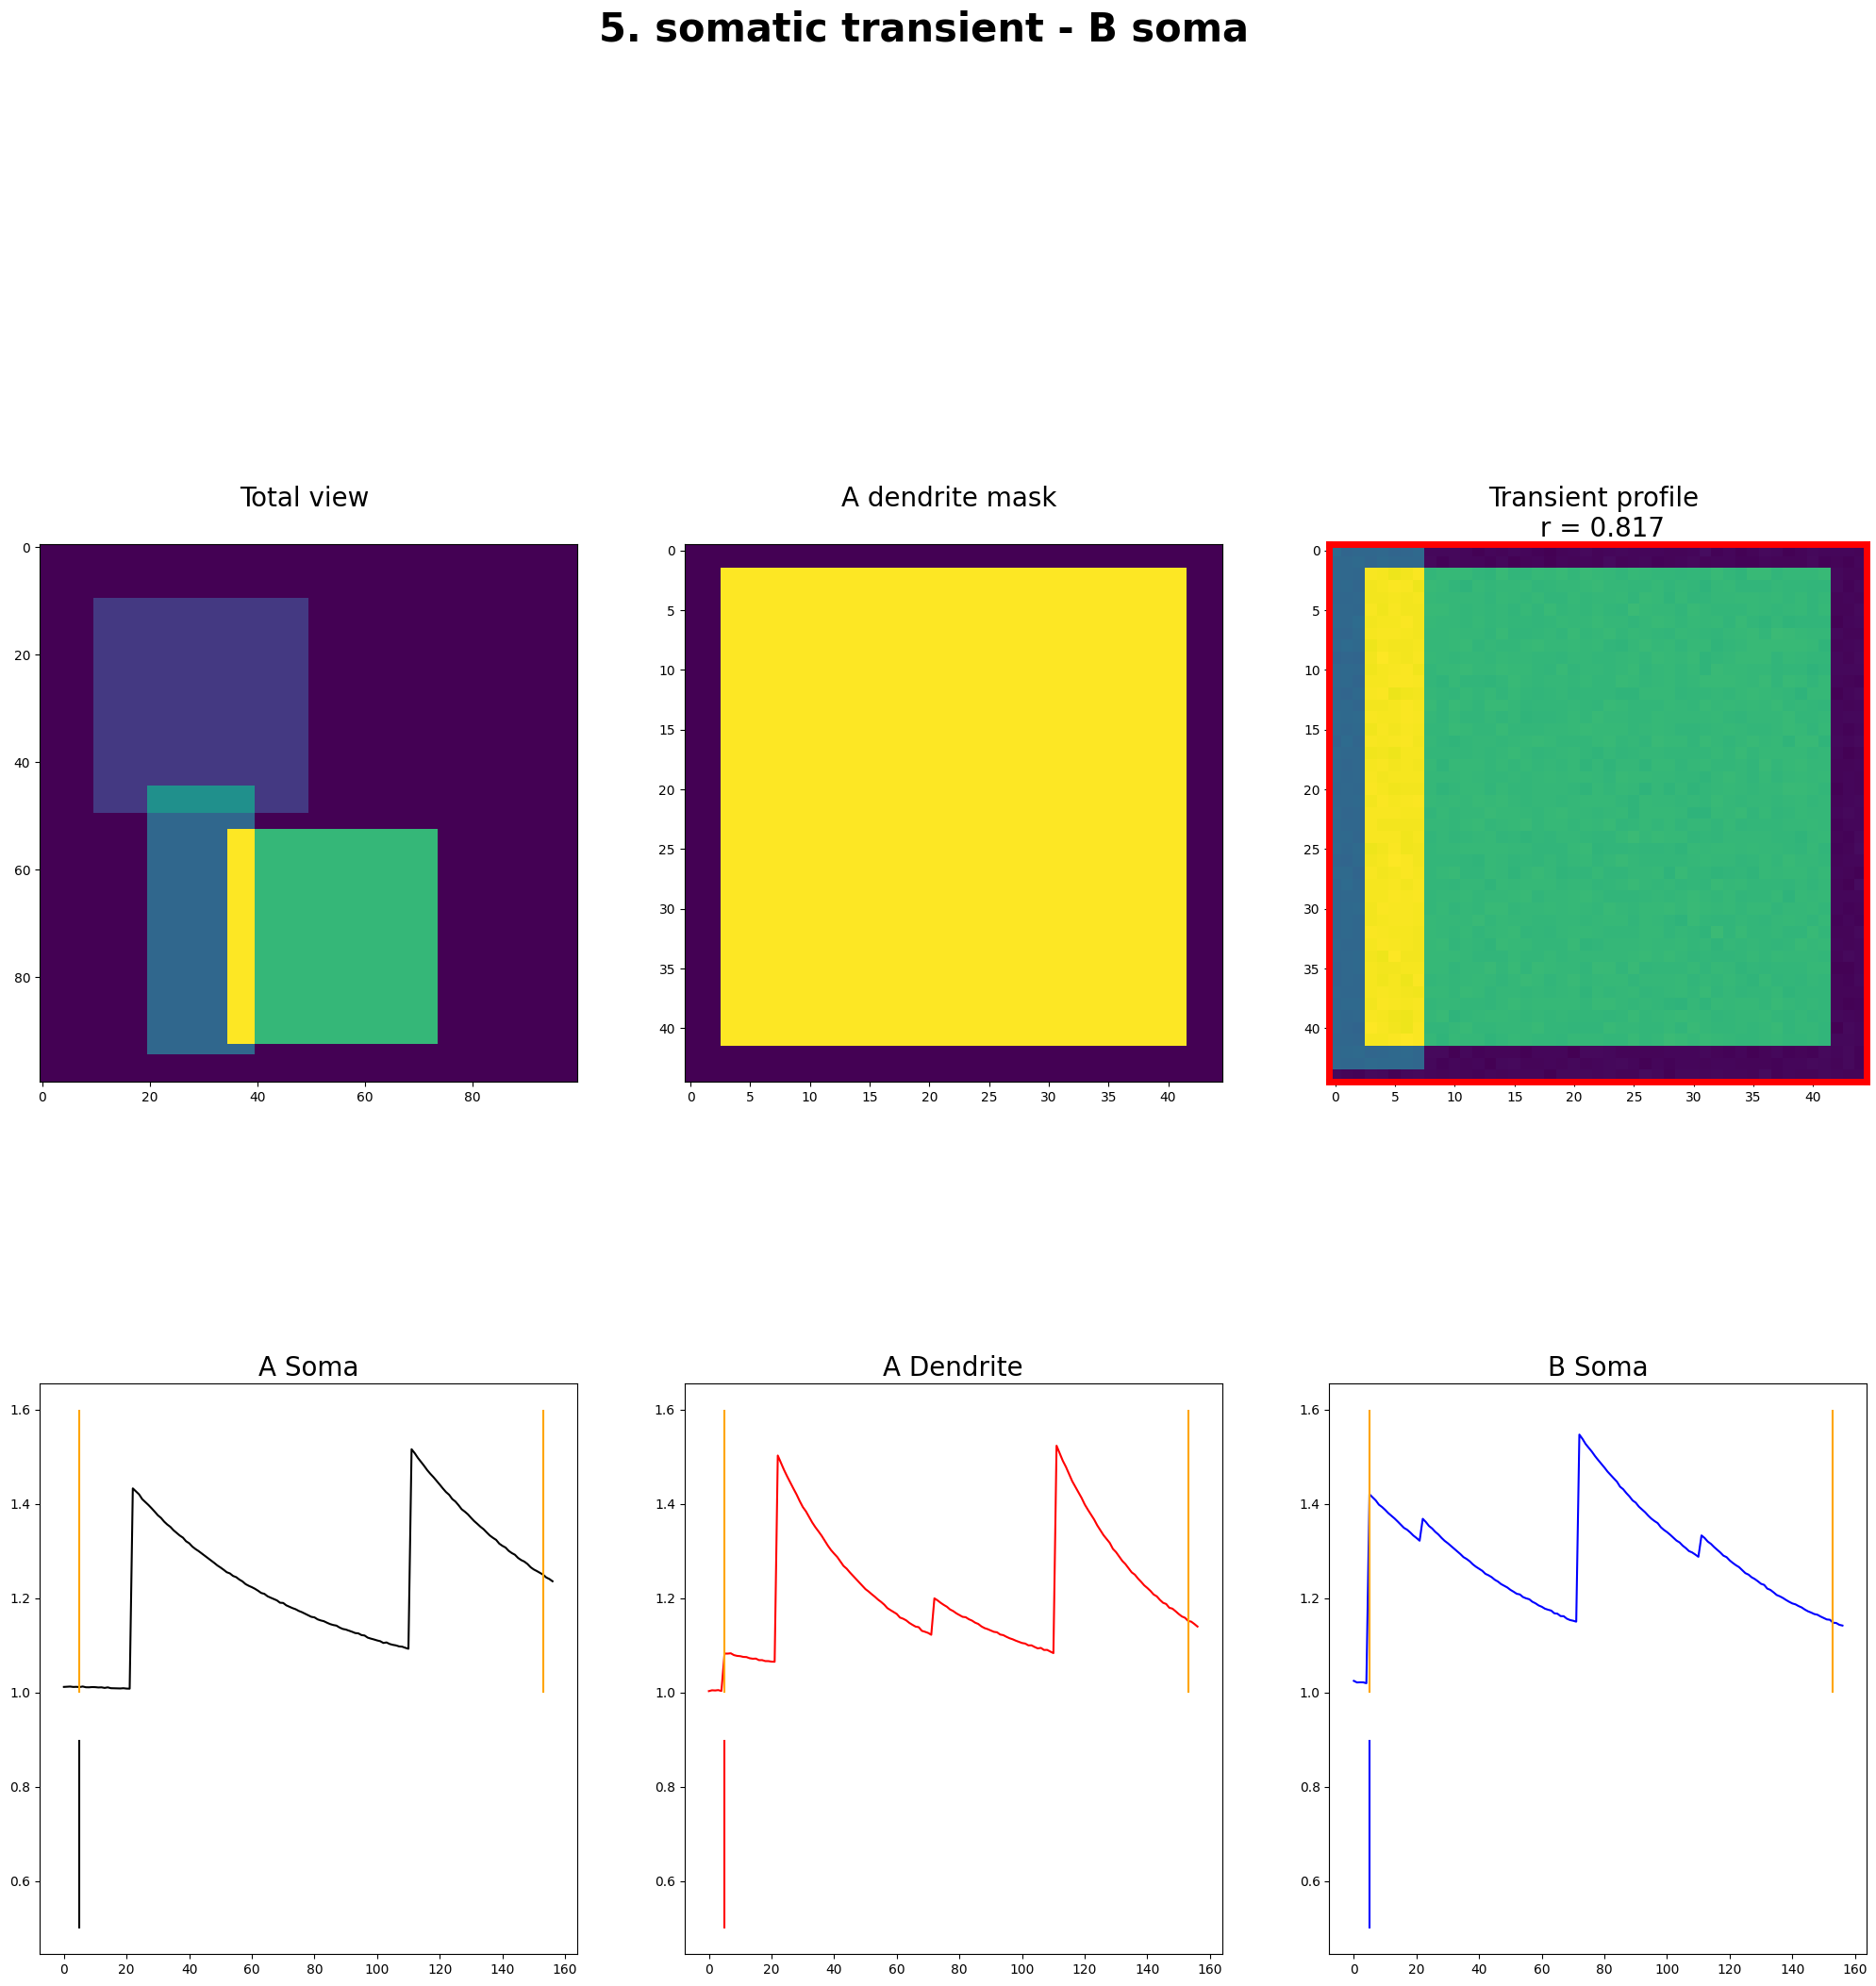

In [ ]:
magazine(synthetic_b_soma_signal_smooth, b_soma_source_prof, synthetic_b_soma_base_profile,
       lista_lower, lista_upper, '{0}. somatic transient - B soma', 'transients/final_transients/b_soma_magazine.pdf') #{0}...